In [1]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings
from joblib import Parallel, delayed

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import plot_random_groups, plot_posteriors, kl_divergences

import seaborn as sns



In [2]:
# Work in progess, this notebook is meant to plot several different randomly selected ensembles, subsets of the 200 that are avaiable

In [3]:
def plot_with_line(dfs,vars,labels=None):
    # dfs   : any number of data frames containing posterior samples
    # vars  : list of the names of variables contained in the dfs
    # labels: list of names for each df for graphing 
    
    sns.set_theme(palette='colorblind')
    rows = int(np.ceil(len(vars)/2))
    cols = 2
    named = True
    if labels is None:
        named = False  # Check if user passed in df labels
        print("debug")
        
    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
    
    bar = 0
    for df in dfs:
        foo = 0
        for i in range(rows):
            for j in range (cols):            
                var = vars[foo]
                if named:
                    sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)],label=labels[bar])
                else:
                    sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)],label=bar)
                foo += 1
                axes[int(i),int(j)].legend()
                
                precision = int(np.log10( (np.max(dfs[bar][var]) - np.min(dfs[bar][var])) / 10000 ))
                # A little janky. Grab order of magnitude estimate to use for the bins in the mode calculation
                

                linexs = round(dfs[bar][var],int(np.abs(precision))).mode().values
                if not bar:
                    c = 'blue'
                else:
                    c = 'orange'
                    
                for linex in linexs:
                    axes[int(i),int(j)].axvline(x=linex, linestyle='--',color=c)
                    print(var,linex)
        bar += 1
        print(bar)
    plt.legend()

In [4]:
emulator_dirs = ['/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_500t_1000e','/data/work/antarctica_calibration/speedemulator/emulator_dirs/rc_50m_500t_1000e']
samples_files = {}

rc_samples_file = "/data/work/antarctica_calibration/speed_calibration_regularized_coulomb_128.csv"
pp_samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"

for emulator_dir in emulator_dirs:
    # This is janky, should really stop using file names as indicators
    if 'rc_' in emulator_dir:
        samples_files[emulator_dir] = rc_samples_file
        print('rc')
    else:
        samples_files[emulator_dir] = pp_samples_file
        print('pp')

frac         = 0.1

print("Loading prior samples\n")
rc_samples = pd.read_csv(rc_samples_file).drop(columns=["id"])
pp_samples = pd.read_csv(pp_samples_file).drop(columns=["id"])

X_keys = rc_samples.keys()

l_post = []


pp
rc
Loading prior samples



In [5]:
posterior_dfs = []
df_models     = []
titles        = []
for emulator_dir in emulator_dirs:
    X_list = []
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    df_models.append(models)
    titles.append(emulator_dir)



Loading posterior samples

Merging posteriors into dataframe
Loading posterior samples

Merging posteriors into dataframe


In [6]:
foo = []
for i in range(100):
    foo.append(i)
bar = pd.DataFrame(foo,columns=['i'])
bar.to_csv('/home/kblum/local/pism/sources/pism-emulator/speedemulator/experiment_dirs/bar.csv')
names = ['pp','rc']

In [7]:
#plot_posteriors(posterior_dfs, X_keys, labels=names)

In [8]:
#plot_with_line(posterior_dfs, X_keys, labels=names)

In [9]:
thin_by = .1
slide_law = int(1) # Depends on the order in which directories were accessed
if thin_by > 0:
    cor_df = posterior_dfs[slide_law].drop('Model',axis=1).sample(frac=thin_by)
    #cor_df = posterior_dfs[slide_law].iloc[::100,:].drop('Model',axis=1)
else:
    cor_df = posterior_dfs[slide_law].drop('Model',axis=1)

In [10]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

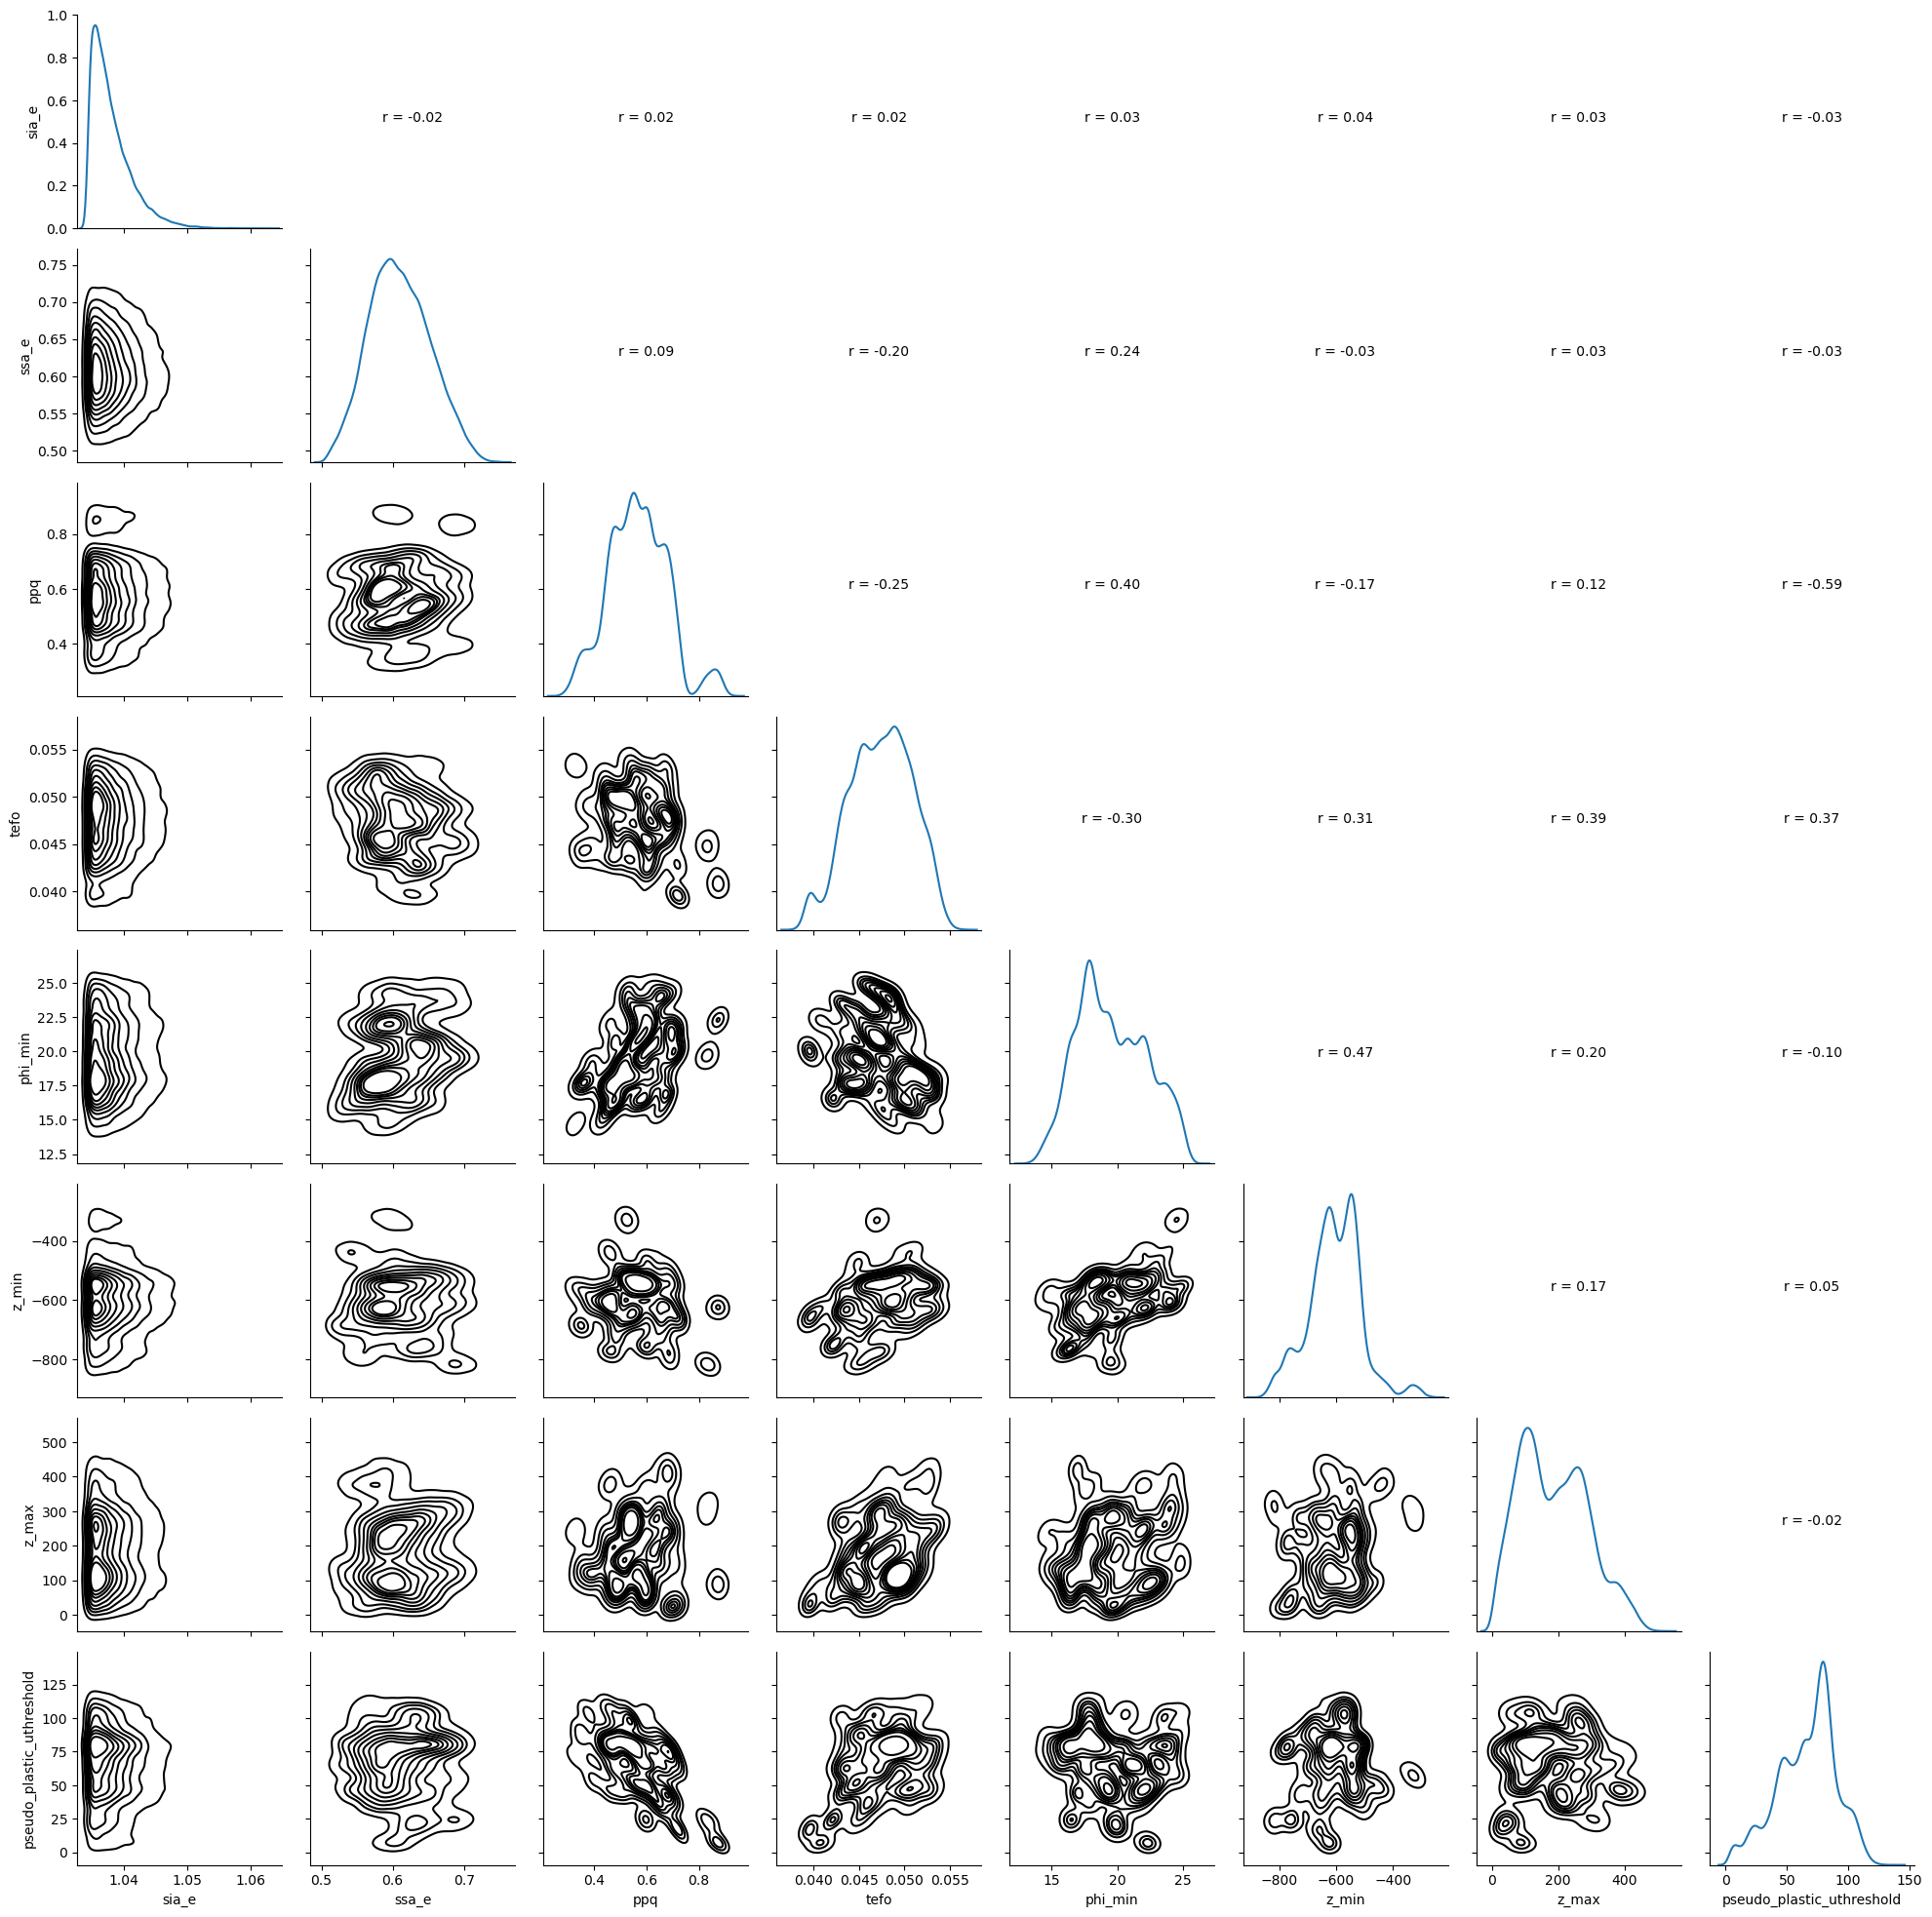

In [11]:
g = sns.PairGrid(cor_df,diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,color='k')
g.map_upper(reg_coef)

In [46]:
cor_df = posterior_dfs[1][posterior_dfs[1]['Model'].isin([4])].drop('Model',axis=1)

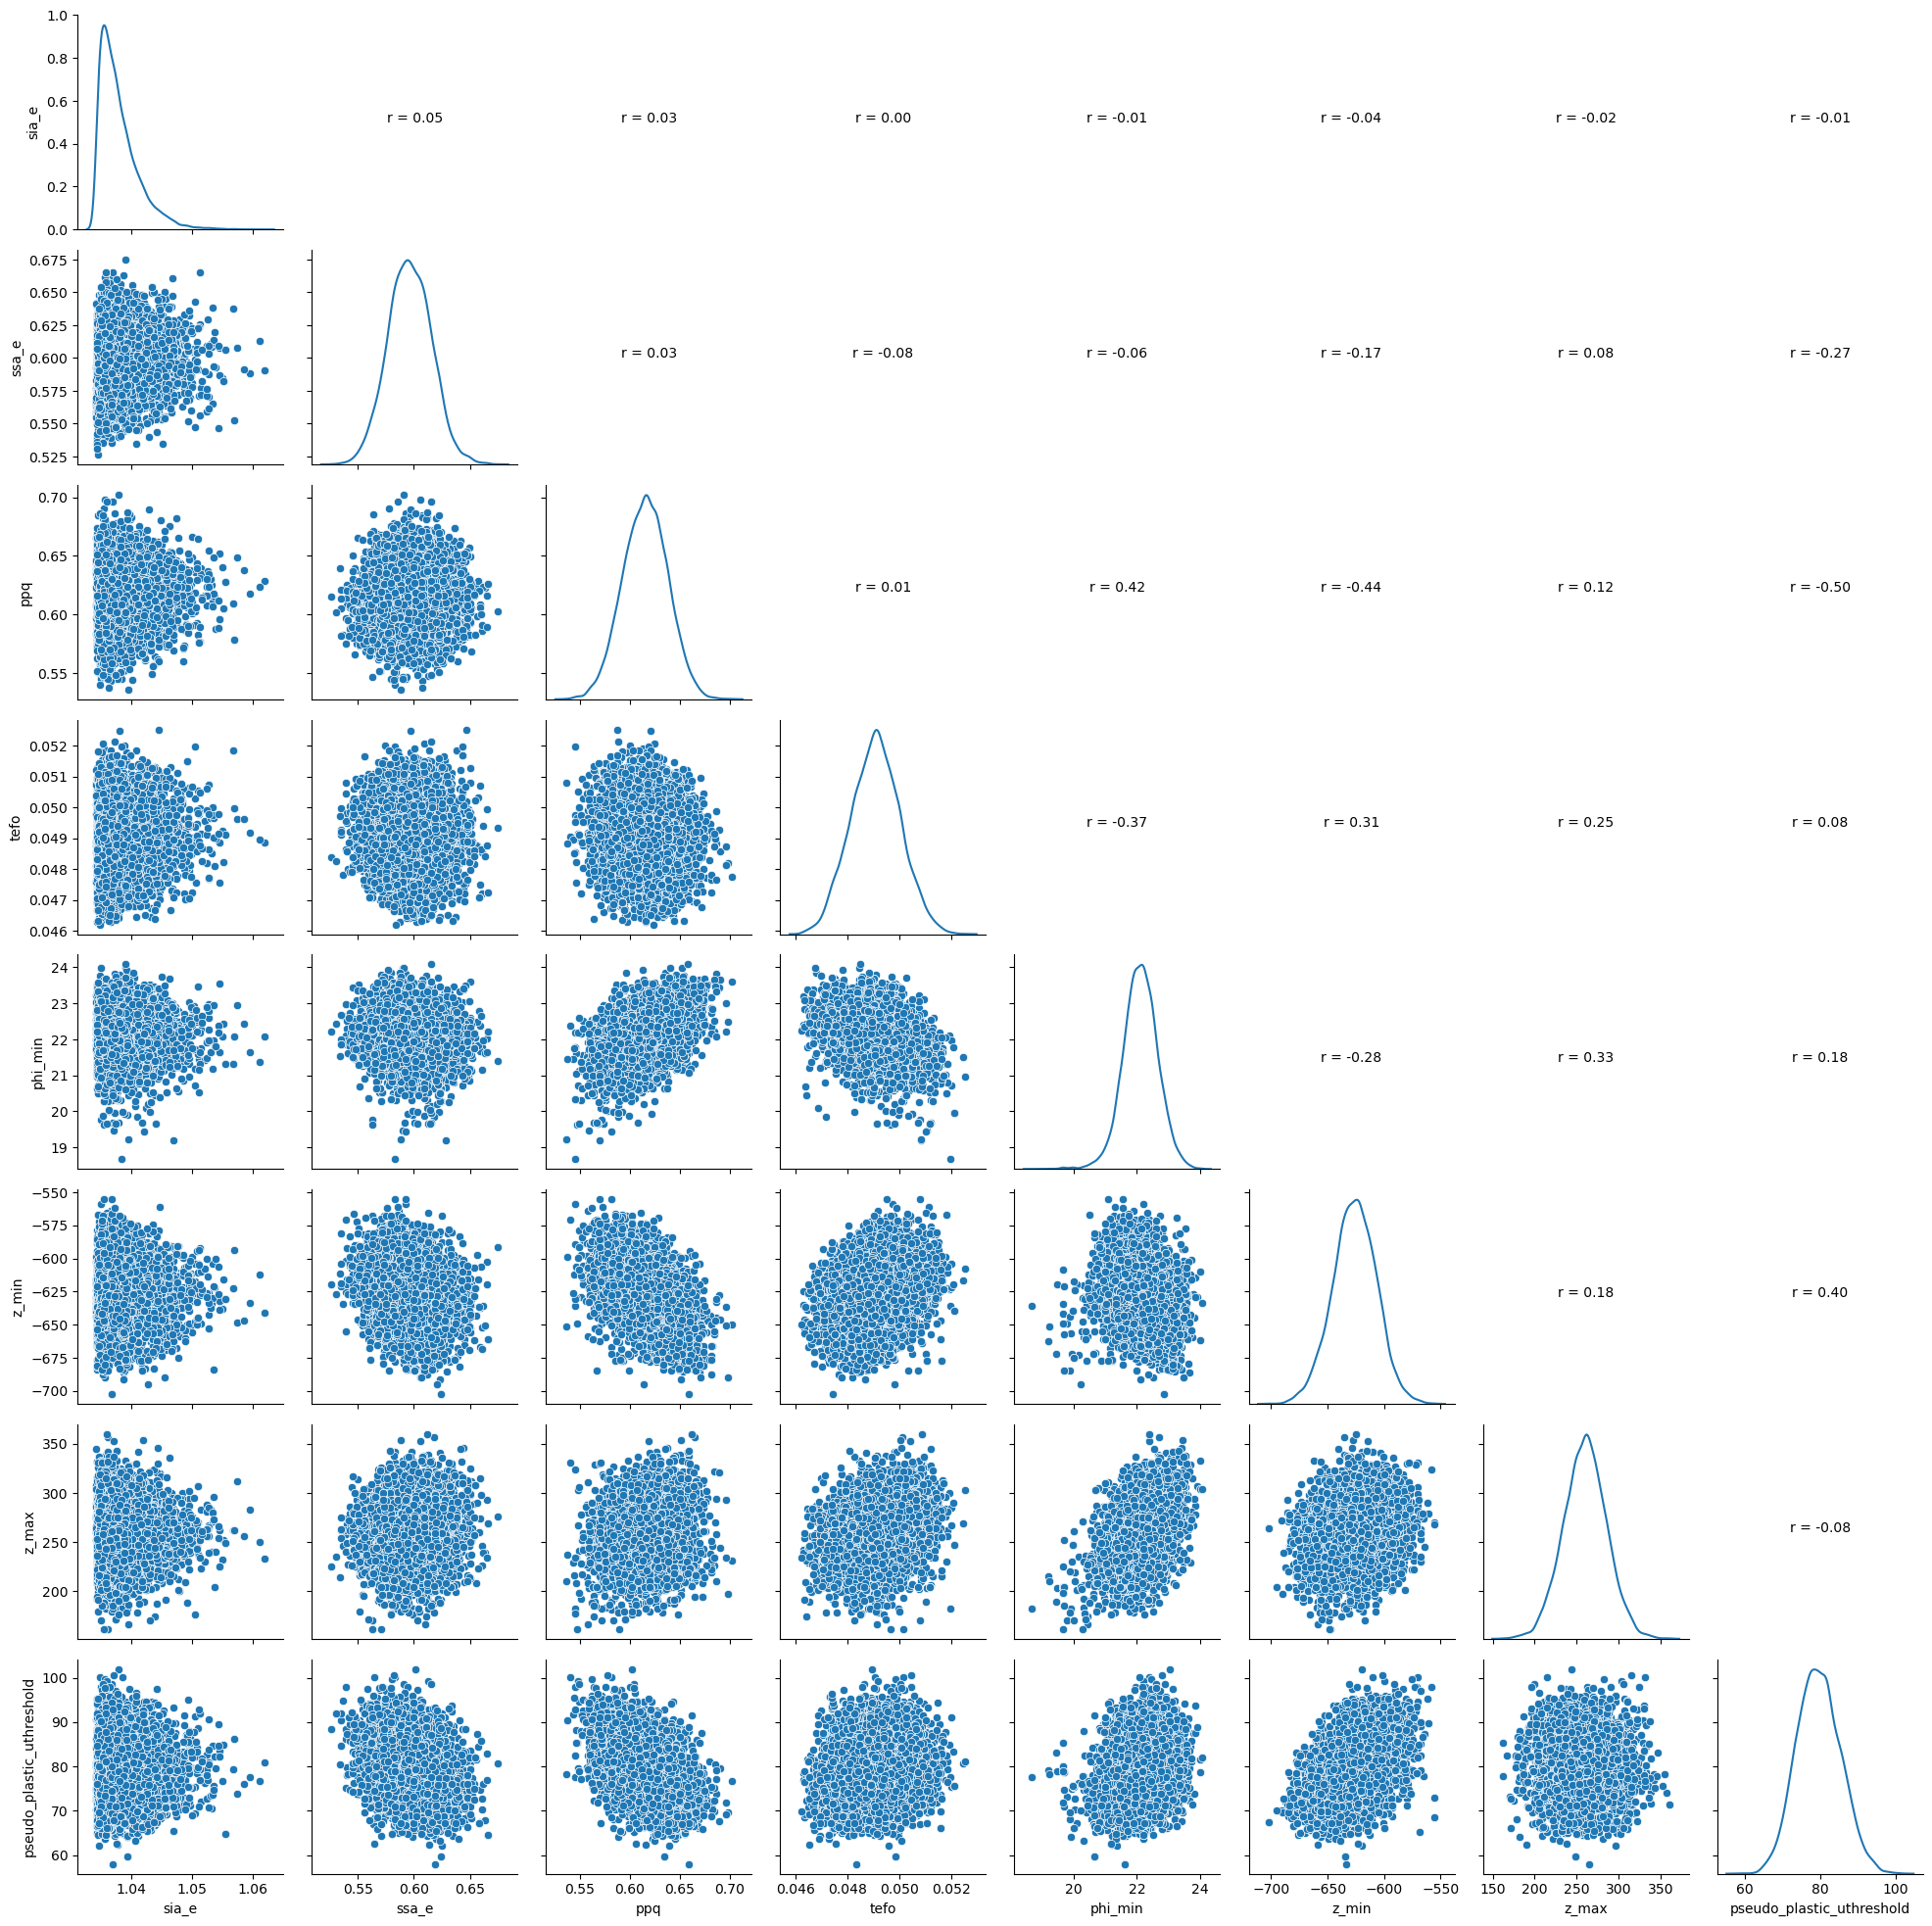

In [47]:
g = sns.PairGrid(cor_df,diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_upper(reg_coef)